<a href="https://colab.research.google.com/github/Vidi005/IDCamp-Dicoding-Challenge-SDGs-2020/blob/master/Plant_Leaf_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Farm Doctor**

Program ML untuk klasifikasi penyakit pada daun tanaman
<br>
Program ini dibuat menggunakan CNN dengan library Keras dan backend TensorFlow.

## Memasang Kaggle untuk Mengimpor Dataset dari Kaggle

In [ ]:
!pip install kaggle

## Upload Kaggle API

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vidi005","key":"9fce1c2f299c8e658ea0b78f1cce224f"}'}

## Menyimpan File Kaggle API untuk Download Datasets

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Preprocessing Datasets

### Mendwonload Dataset Plant Diseases

Dataset didownload dari link berikut:
<br>
https://www.kaggle.com/daoliu/plant-622

In [ ]:
!kaggle datasets download -d daoliu/plant-622

100% 1.33G/1.34G [00:11<00:00, 47.7MB/s]
100% 1.34G/1.34G [00:11<00:00, 122MB/s] 


### Menampilkan List Folder Content

In [ ]:
!ls

kaggle.json  plant-622.zip  sample_data


### Mengekstrak Dataset yang Sudah didownload

In [ ]:
#Menyimpan hasil ekstrak ke dalam folder datasets
import zipfile,os
local_zip = "plant-622.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

In [ ]:
#Menghapus folder dataset pelatihan yang tidak diperlukan
import shutil
shutil.rmtree("/content/datasets/train/Blueberry___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Orange___Haunglongbing_(Citrus_greening)", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Peach___Bacterial_spot", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Peach___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Raspberry___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Soybean___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/train/Squash___Powdery_mildew", ignore_errors=False, onerror=None)

#Menghapus dataset validasi yang tidak diperlukan
#Dataset validasi yang digunakan diambil 20% dari dataset pelatihan menggunakan image generator
shutil.rmtree("/content/datasets/valid", ignore_errors=False, onerror=None)

#Menghapus dataset pengujian yang tidak diperlukan
shutil.rmtree("/content/datasets/test/Blueberry___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Orange___Haunglongbing_(Citrus_greening)", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Peach___Bacterial_spot", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Peach___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Raspberry___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Soybean___healthy", ignore_errors=False, onerror=None)
shutil.rmtree("/content/datasets/test/Squash___Powdery_mildew", ignore_errors=False, onerror=None)

## Mengimpor Libraries yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from skimage.transform import resize
from keras.utils.np_utils import to_categorical

# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=e053d151e4ec5222f407363bb7d9f1c27fa4f1957d56e537daeb5748631161dd
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


## Menampilkan Versi TensorFlow yang digunakan

In [ ]:
print(tf.__version__)

2.3.0
time: 2.45 ms


## Preprocessing Datasets

### Membuat Objek ImageDataGenerator & Data Augmentation

Membuat obyek gambar dataset dengan ImageDataGenerator, Autmentasi dataset, dan Membagi dataset validasi (validation) sebesar 20% dan dataset pelatihan (training) sebesar 80%.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 6.46 ms


### Menggunakan Obyek ImageDataGenerator

In [ ]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("datasets/train")

img_size = 224
batch_size = 128

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation',
    class_mode= 'categorical')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Apple___Apple_scab',
          'Apple___Black_rot',
          'Apple___Cedar_apple_rust',
          'Apple___healthy',
          'Cherry_(including_sour)___Powdery_mildew',
          'Cherry_(including_sour)___healthy',
          'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
          'Corn_(maize)___Common_rust_',
          'Corn_(maize)___Northern_Leaf_Blight',
          'Corn_(maize)___healthy',
          'Grape___Black_rot',
          'Grape___Esca_(Black_Measles)',
          'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
          'Grape___healthy',
          'Pepper,_bell___Bacterial_spot',
          'Pepper,_bell___healthy',
          'Potato___Early_blight',
          'Potato___Late_blight',
          'Potato___healthy',
          'Strawberry___Leaf_scorch',
          'Strawberry___Leaf_scorch',
          'Tomato___Bacterial_spot',
          'Tomato___Early_blight',
          'Tomato___Late_blight',
          'Tomato___Leaf_Mold',
          'Tomato___Septoria_leaf_spot',
          'Tomato___Spider_mites Two-spotted_spider_mite',
          'Tomato___Target_Spot',
          'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
          'Tomato___Tomato_mosaic_virus',
          'Tomato___healthy']

for i,label in enumerate(labels):
    folder = os.path.join("datasets/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 34429 images belonging to 31 classes.
Found 8595 images belonging to 31 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 31)
Bentuk array dari dataset validation (validasi) adalah: (128, 224, 224, 3) (128, 31)
Bentuk array dari dataset test (pengujian) adalah: (601, 224, 224, 3) (601,)
time: 14.6 s


## Menyimpan Label Datasets

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Cherry_(including_sour)___Powdery_mildew': 4, 'Cherry_(including_sour)___healthy': 5, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6, 'Corn_(maize)___Common_rust_': 7, 'Corn_(maize)___Northern_Leaf_Blight': 8, 'Corn_(maize)___healthy': 9, 'Grape___Black_rot': 10, 'Grape___Esca_(Black_Measles)': 11, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12, 'Grape___healthy': 13, 'Pepper,_bell___Bacterial_spot': 14, 'Pepper,_bell___healthy': 15, 'Potato___Early_blight': 16, 'Potato___Late_blight': 17, 'Potato___healthy': 18, 'Strawberry___Leaf_scorch': 19, 'Strawberry___healthy': 20, 'Tomato___Bacterial_spot': 21, 'Tomato___Early_blight': 22, 'Tomato___Late_blight': 23, 'Tomato___Leaf_Mold': 24, 'Tomato___Septoria_leaf_spot': 25, 'Tomato___Spider_mites Two-spotted_spider_mite': 26, 'Tomato___Target_Spot': 27, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 28, 'Tomato___Tomato_mosaic_virus'

## Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (pre-trained convnets)

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step
time: 6.66 s


### Feature Extraction

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Membuat Model Arsitektur CNN

Membuat arsitektur CNN mulai dari Lapisan Masukkan (Input Layer), Lapisan Konvolusi (Convolution Layer), Lapisan aktivasi (Activation Layer), Pooling Layer, sampai Lapisan terhubung erat (Fully Connected Layer/Densely Connected Layer).

In [ ]:
model = tf.keras.models.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(31, activation='softmax')
])

time: 192 ms


### Mengkompilasi Model

In [ ]:
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 31)                1023      
Total params: 3,524,831
Trainable params: 295,967
Non-trainable params: 3,228,864
_________________________________________________________________
time: 26.5 ms


### Melathi Model

In [ ]:
#es = EarlyStopping(monitor="val_loss", patience=7, verbose=1, min_delta=0.09, mode="auto")
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=val_generator)

Epoch 1/20
269/269 [==============================] - 484s 2s/step - loss: 1.2826 - acc: 0.6283 - val_loss: 0.5233 - val_acc: 0.8361
Epoch 2/20
269/269 [==============================] - 483s 2s/step - loss: 0.3888 - acc: 0.8723 - val_loss: 0.3859 - val_acc: 0.8734
Epoch 3/20
269/269 [==============================] - 481s 2s/step - loss: 0.3044 - acc: 0.8981 - val_loss: 0.3542 - val_acc: 0.8844
Epoch 4/20
269/269 [==============================] - 479s 2s/step - loss: 0.2640 - acc: 0.9116 - val_loss: 0.3066 - val_acc: 0.9020
Epoch 5/20
269/269 [==============================] - 494s 2s/step - loss: 0.2331 - acc: 0.9215 - val_loss: 0.3093 - val_acc: 0.9025
Epoch 6/20
269/269 [==============================] - 497s 2s/step - loss: 0.2244 - acc: 0.9242 - val_loss: 0.2747 - val_acc: 0.9109
Epoch 7/20
269/269 [==============================] - 504s 2s/step - loss: 0.2136 - acc: 0.9288 - val_loss: 0.2946 - val_acc: 0.9047
Epoch 8/20
269/269 [==============================] - 504s 2s/step - 

### Menampilkan Grafik Model Hasil Pelatihan

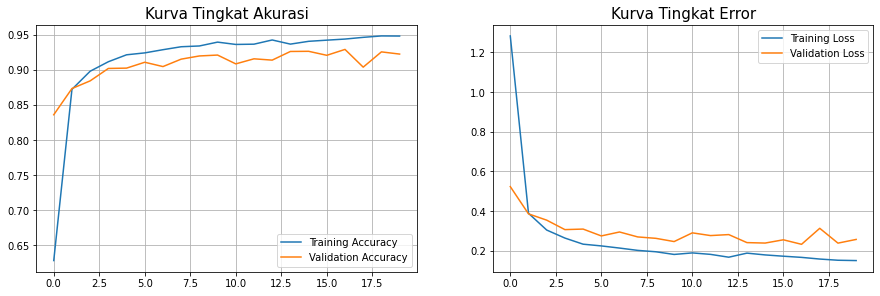

time: 339 ms


In [ ]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(history.history["acc"],label = "Training Accuracy")
plt.plot(history.history["val_acc"],label = "Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Memuat Dataset Pengujian

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

time: 1.46 ms


## Evaluasi Model

In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[ 6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9

## Membuat Confusion Matrix

Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan]
 [0.02 0.85 0.08 0.04 0.   0.   0.02]
 [0.   0.06 0.92 0.   0.02 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [ nan  nan  nan  nan  nan  nan  nan]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


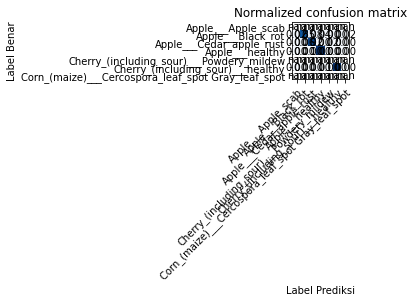

time: 442 ms


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

## Menyimpan dan Konversi Model ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Plant_Leaf_Diseases_Classification_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
time: 14.9 s


Menyimpan model tflite versi kompatibel quantized

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('Plant_Leaf_Diseases_Classification_MobileNet_Quantized.tflite', 'wb') as f:
  f.write(tflite_model)